In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

import tensorflow as tf

import os
import pickle
import numpy as np

print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.1.0
2.0.8


In [2]:
num_examples_per_class = 5000

classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe','banana','bandage',
           'barn','baseball bat','baseball','basket','basketball','bathtub','beach','bear','beard','bed',
           'bee','belt','bicycle','binoculars','birthday cake','blueberry','book','boomerang','bottlecap','bowtie',
           'bracelet','brain','bread','broom','bulldozer','bus','bush','butterfly','cactus','cake',
           'calculator','calendar','camel','camera','campfire','candle','cannon','canoe','car','carrot',
           'cello','computer','cat','chandelier','clock','cloud','coffee cup','compass','cookie','couch',
           'cow','crab','crayon','crocodile','crown','cup','diamond','dog','dolphin','donut',
           'dragon','dresser','drill','drums','duck','dumbbell','ear','elbow','elephant','envelope',
           'eraser','eye','eyeglasses','face','fan','feather','fence','finger','fire hydrant','fireplace',
           'firetruck','fish','flamingo','flashlight','flip flops','floor lamp','flower','flying saucer','foot','fork']

num_classes = len(classes)

## Load the dataset

In [ ]:
'''
# Build your own dataset from QuickDraw raw data
quickdraws = [np.load("../../data/{}.npy".format(qdraw))[:num_examples_per_class] for qdraw in classes]

# Concat the arrays together
x_data = np.concatenate(quickdraws)
'''

In [3]:
# Load data here
x_data = np.load("./data/quickdraw/x_data_100_classes_5k.npy")

x_data = x_data.reshape(x_data.shape[0], 28, 28, 1)
x_data = x_data.astype('float32')
x_data /= 255

print(x_data.shape)

labels = [np.full((num_examples_per_class,), classes.index(qdraw)) for qdraw in classes]

# Concat the arrays together
y_data = np.concatenate(labels)
y_data = keras.utils.to_categorical(y_data, num_classes)

print(y_data.shape)

# Partition data into training set and validation set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

(500000, 28, 28, 1)
(500000, 100)


In [5]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

## Define the Model

In [6]:
Inp = Input(shape=(28, 28, 1))
# Convolution block 1
x = Conv2D(32, kernel_size=(3, 3), activation='relu', name='Conv_01')(Inp)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', name='Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2), name='MaxPool_01')(x)
x = Dropout(0.25, name='Dropout_01')(x)
# Convolution block 2
x = Conv2D(64, kernel_size=(3, 3), activation='relu', name='Conv_03')(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', name='Conv_04')(x)
x = MaxPooling2D(pool_size=(2, 2), name='MaxPool_02')(x)
x = Dropout(0.5, name='Dropout_02')(x)

x = Flatten(name='Flatten_01')(x)
x = Dense(256, activation='relu', name='Dense_01')(x)
x = Dropout(0.5, name='Dropout_03')(x)
output = Dense(num_classes, activation='softmax', name='Dense_02')(x)

In [7]:
# Define model inputs and output
model = Model(Inp, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_01 (Conv2D)             (None, 26, 26, 32)        320       
_________________________________________________________________
Conv_02 (Conv2D)             (None, 24, 24, 32)        9248      
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (None, 12, 12, 32)        0         
_________________________________________________________________
Dropout_01 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
Conv_03 (Conv2D)             (None, 10, 10, 64)        18496     
_________________________________________________________________
Conv_04 (Conv2D)             (None, 8, 8, 64)          36928     
__________

In [8]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])

## Train the model

In [10]:
batch_size = 128
epochs = 10

# Fit the model on the batches generated by datagen.flow().
hist = model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Epoch 1/10
3125/3125 [==============================] - 51s - loss: 3.0194 - acc: 0.2674 - val_loss: 1.7737 - val_acc: 0.5554
Epoch 2/10
3125/3125 [==============================] - 50s - loss: 2.3533 - acc: 0.4101 - val_loss: 1.5025 - val_acc: 0.6195
Epoch 3/10
3125/3125 [==============================] - 50s - loss: 2.1711 - acc: 0.4525 - val_loss: 1.3973 - val_acc: 0.6438
Epoch 4/10
3125/3125 [==============================] - 50s - loss: 2.0888 - acc: 0.4725 - val_loss: 1.3465 - val_acc: 0.6549
Epoch 5/10
3125/3125 [==============================] - 51s - loss: 2.0303 - acc: 0.4868 - val_loss: 1.3296 - val_acc: 0.6596
Epoch 6/10
3125/3125 [==============================] - 51s - loss: 1.9930 - acc: 0.4956 - val_loss: 1.2690 - val_acc: 0.6757
Epoch 7/10
3125/3125 [==============================] - 51s - loss: 1.9646 - acc: 0.5026 - val_loss: 1.2812 - val_acc: 0.6730
Epoch 8/10
3125/3125 [==============================] - 54s - loss: 1.9442 - acc: 0.5078 - val_loss: 1.2443 - val_acc:

## Evaluate the model

In [12]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
                                                   batch_size=batch_size,
                                                   shuffle=False),
                                      steps=x_test.shape[0] // batch_size,
                                      workers=4)
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))

Model Accuracy = 0.63
Model Loss = 1.44


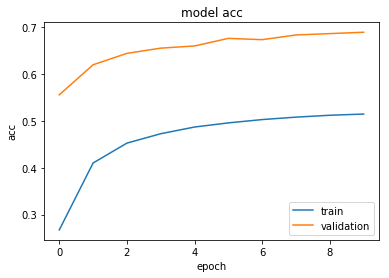

In [14]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    
plot_train(hist)

## Make predictions with the model

In [22]:
def show_image(data):
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(data.reshape(28, 28), cmap='gray_r')
    plt.show()

In [17]:
predict_gen = model.predict_generator(datagen.flow(x_test, y_test,
                                                   batch_size=batch_size,
                                                   shuffle=False),
                                      steps=x_test.shape[0] // batch_size,
                                      workers=4)

Actual Label = cookie vs. Predicted Label = drill


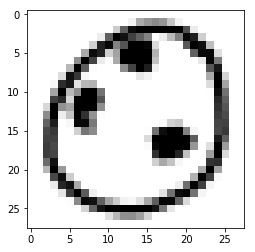

Actual Label = bush vs. Predicted Label = crayon


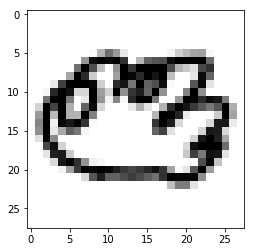

Actual Label = alarm clock vs. Predicted Label = chandelier


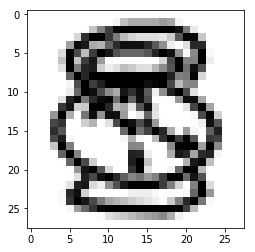

Actual Label = book vs. Predicted Label = cookie


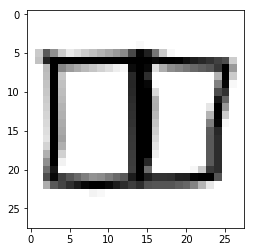

Actual Label = floor lamp vs. Predicted Label = crab


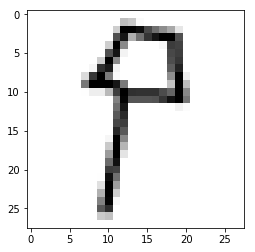

Actual Label = dog vs. Predicted Label = compass


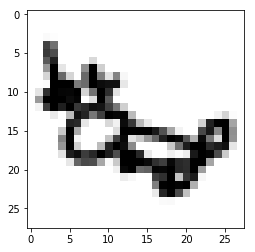

Actual Label = basket vs. Predicted Label = drums


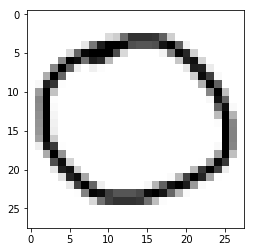

Actual Label = fire hydrant vs. Predicted Label = campfire


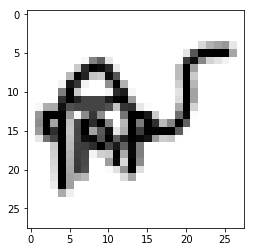

Actual Label = airplane vs. Predicted Label = flying saucer


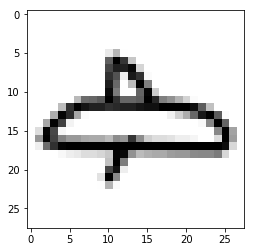

Actual Label = beard vs. Predicted Label = couch


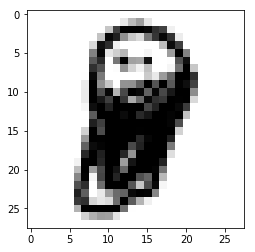

Actual Label = campfire vs. Predicted Label = cow


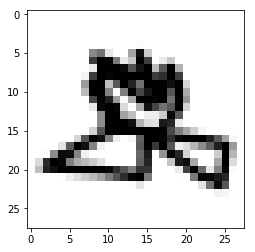

Actual Label = car vs. Predicted Label = bowtie


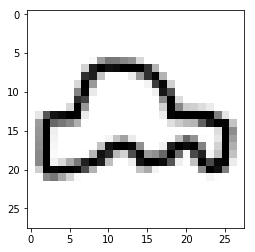

Actual Label = airplane vs. Predicted Label = flower


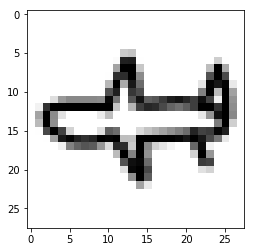

Actual Label = cookie vs. Predicted Label = flip flops


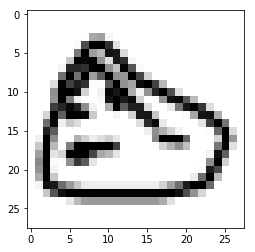

Actual Label = cello vs. Predicted Label = fork


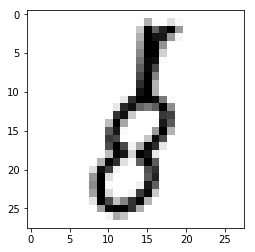

Actual Label = flamingo vs. Predicted Label = donut


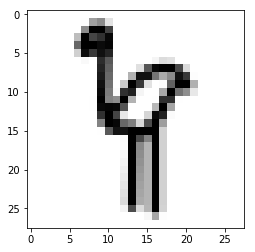

Actual Label = birthday cake vs. Predicted Label = fire hydrant


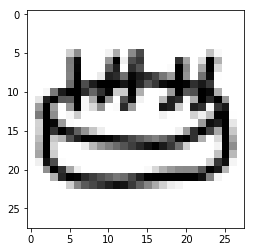

Actual Label = angel vs. Predicted Label = bulldozer


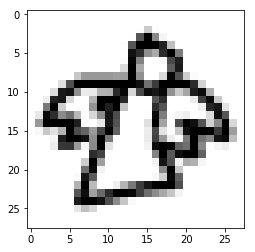

Actual Label = eraser vs. Predicted Label = clock


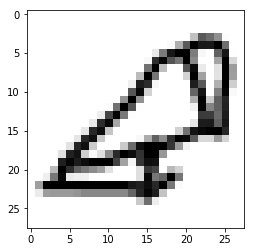

Actual Label = bed vs. Predicted Label = book


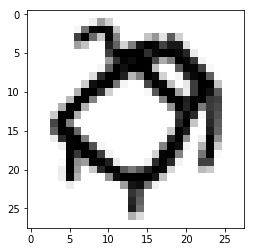

Actual Label = camera vs. Predicted Label = bear


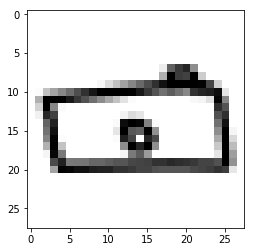

In [25]:
num_predictions = 20

predict_gen = predict_gen[num_predictions:]

for predict_index, predicted_y in enumerate(predict_gen):
    actual_label = classes[np.argmax(y_test[predict_index])]
    predicted_label = classes[np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    show_image(x_test[predict_index])
    if predict_index == num_predictions:
        break

In [15]:
model.save('mini_challenge_01.h5')